In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation, Lambda

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from deepexplain.tensorflow import DeepExplain


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tensorflow_p36_deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


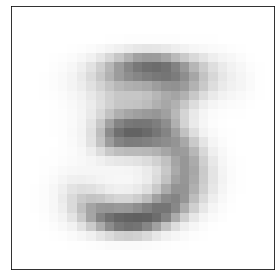

In [3]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [4]:

predictor = Sequential()

predictor.add(Lambda(lambda x: x / 2.0 + 0.5, input_shape=input_shape, name='tanh_to_sigm'))
predictor.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1'))
predictor.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
predictor.add(MaxPooling2D(pool_size=(2, 2)))
predictor.add(Dropout(0.25))
predictor.add(Flatten())
predictor.add(Dense(128, activation='relu', name='dense_1'))
predictor.add(Dropout(0.5))
predictor.add(Dense(num_classes, activation='linear', name='dense_2'))
predictor.add(Activation('softmax'))

predictor.load_weights('saved_models/mnist_binarized_cnn_10_digits.h5')
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
#Tile the ref background to same shape as test set

x_mean_baseline = np.expand_dims(x_mean, axis=-1)


In [6]:

def _deep_explain(method_name, predictor=predictor, x_test_sigm=x_test, y_test=y_test, baseline_sigm=x_mean_baseline) :

    x_test_tanh = (x_test_sigm - 0.5) * 2.0
    baseline_tanh = (baseline_sigm - 0.5) * 2.0
    
    attributions = None
    
    with DeepExplain(session=K.get_session()) as de :
        input_tensor = predictor.layers[0].input

        fModel = Model(inputs=input_tensor, outputs = predictor.layers[-2].output)
        target_tensor = fModel(input_tensor)

        if method_name == 'deeplift' :
            attributions = de.explain(method_name, target_tensor, input_tensor, x_test_tanh, ys=y_test, baseline=baseline_tanh)
        elif method_name == 'intgrad' :
            attributions = de.explain(method_name, target_tensor, input_tensor, x_test_tanh, ys=y_test, baseline=baseline_tanh, steps=10)
        else :
            attributions = de.explain(method_name, target_tensor, input_tensor, x_test_tanh, ys=y_test)
        
    return attributions


In [7]:
#Specify deeplift attribution models

attribution_suffixes = [
    'gradient',
    'rescale',
    'integrated_gradients',
    'eta_lrp'
]

attribution_method_names = [
    'grad*input',
    'deeplift',
    'intgrad',
    'elrp'
]


Attribution method = 'gradient'
Test image 0:


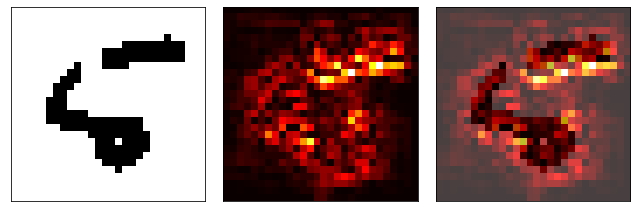

Test image 1:


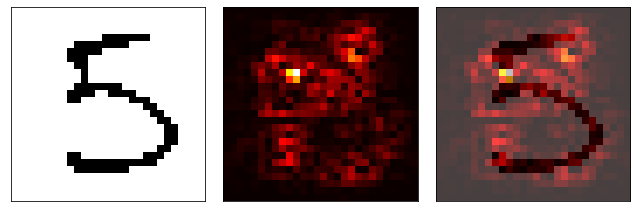

Test image 2:


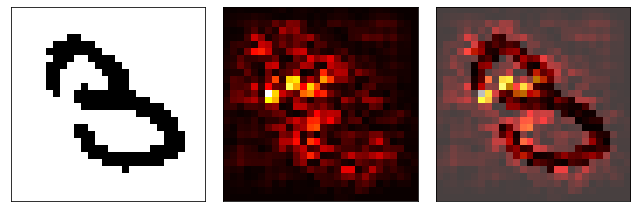

Test image 3:


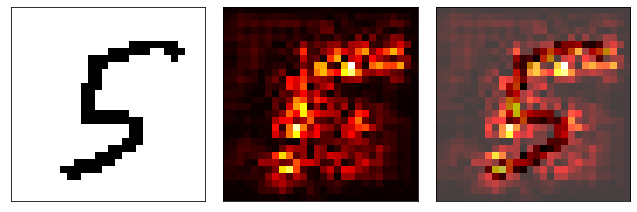

Test image 4:


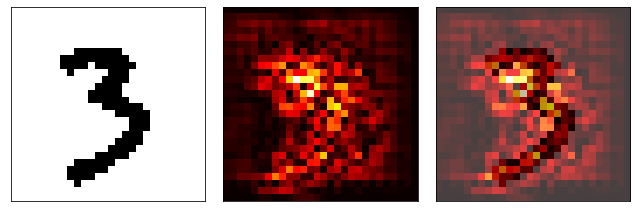

Test image 5:


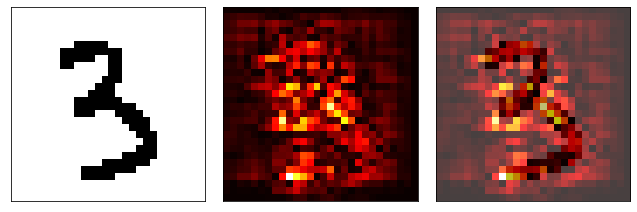

Test image 6:


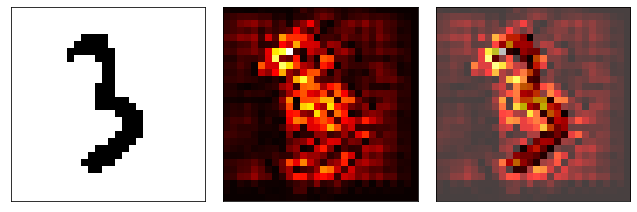

Test image 7:


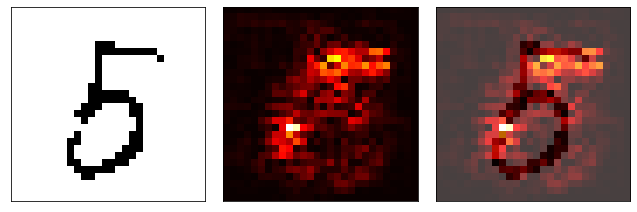

Test image 8:


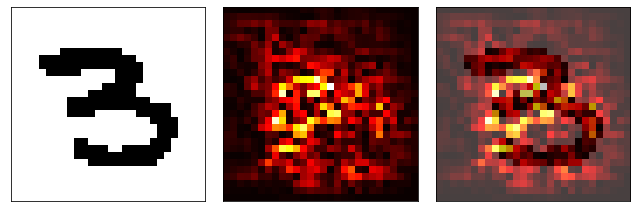

Test image 9:


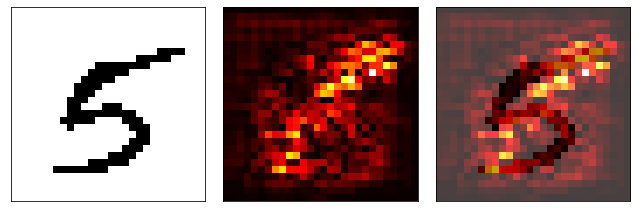

Attribution method = 'rescale'
Test image 0:


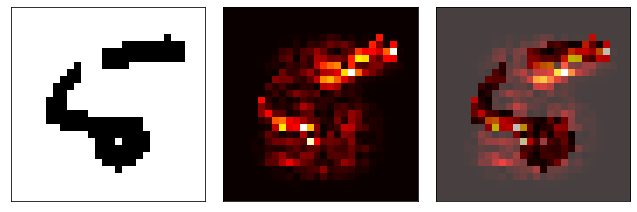

Test image 1:


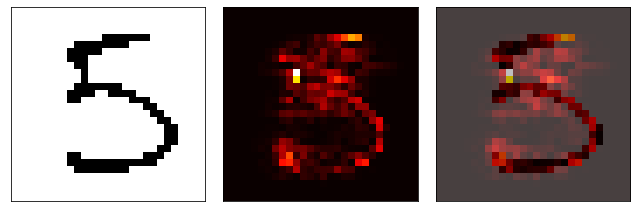

Test image 2:


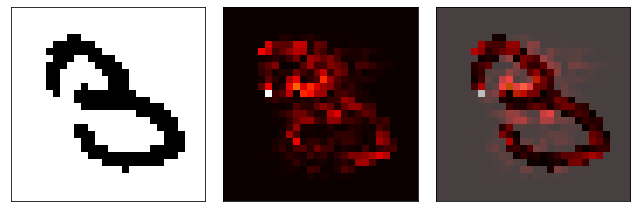

Test image 3:


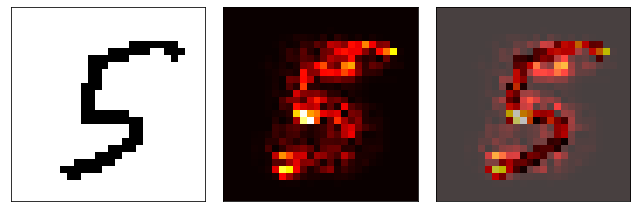

Test image 4:


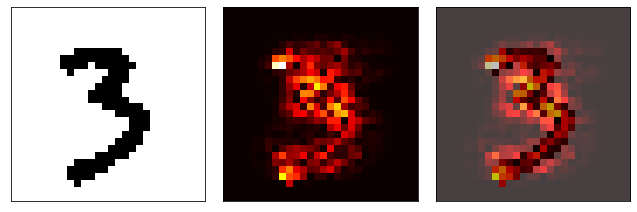

Test image 5:


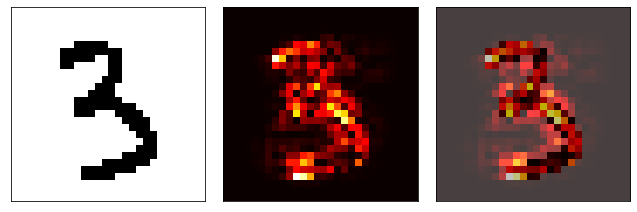

Test image 6:


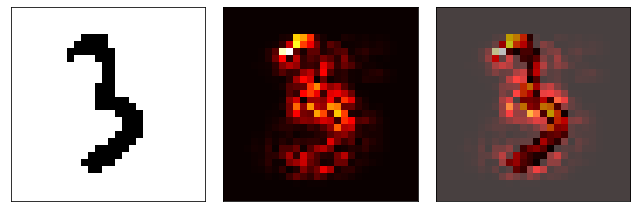

Test image 7:


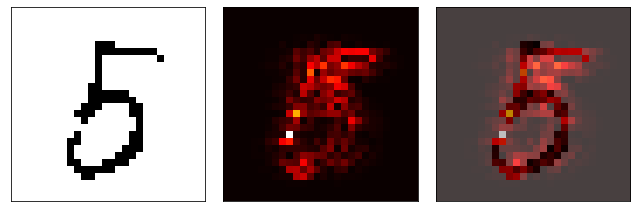

Test image 8:


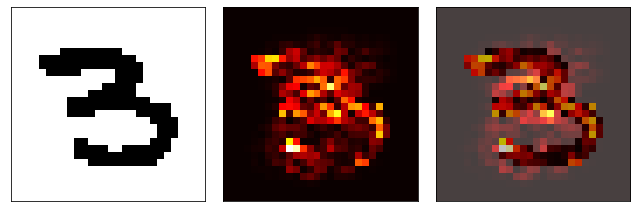

Test image 9:


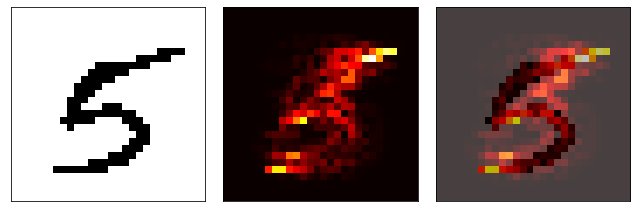

Attribution method = 'integrated_gradients'
Test image 0:


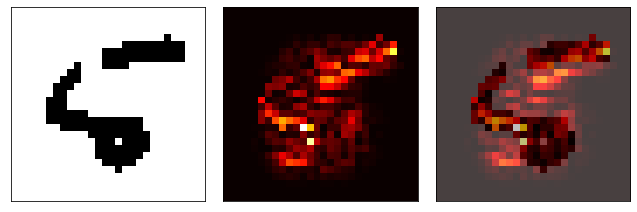

Test image 1:


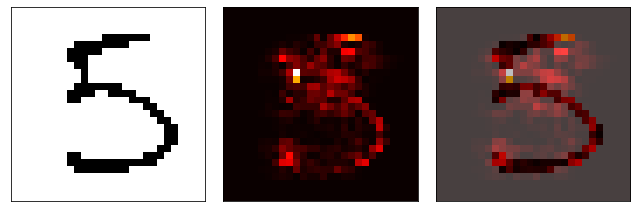

Test image 2:


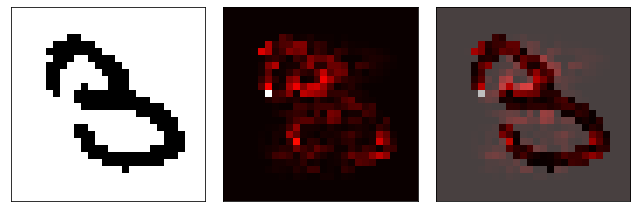

Test image 3:


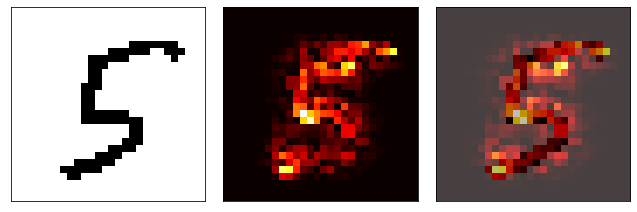

Test image 4:


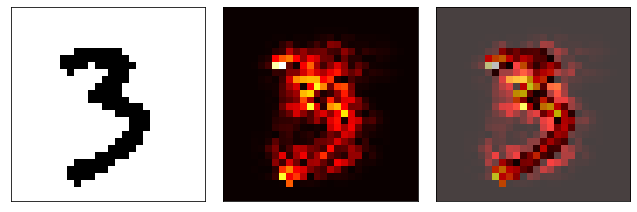

Test image 5:


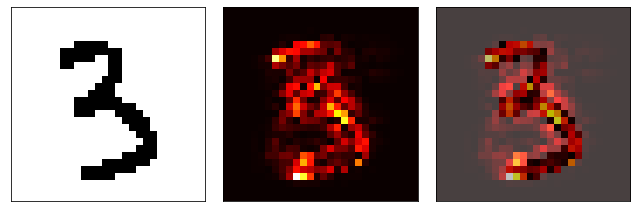

Test image 6:


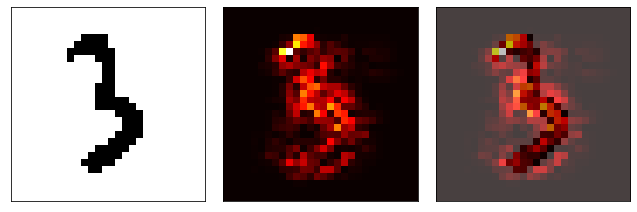

Test image 7:


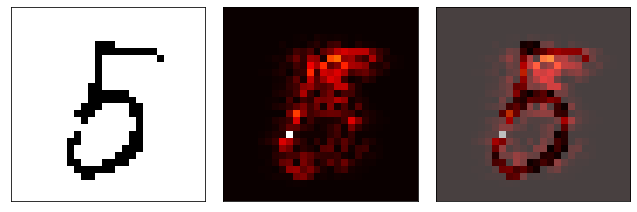

Test image 8:


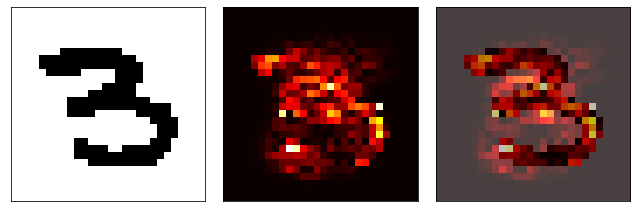

Test image 9:


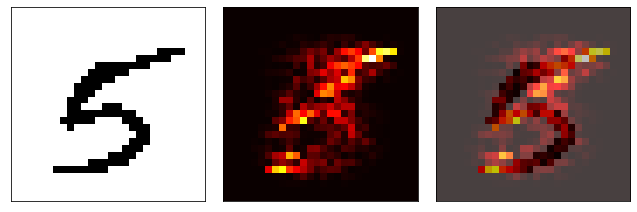

Attribution method = 'eta_lrp'
Test image 0:


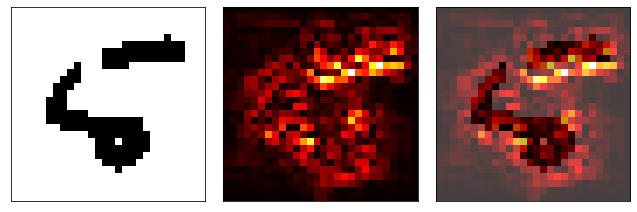

Test image 1:


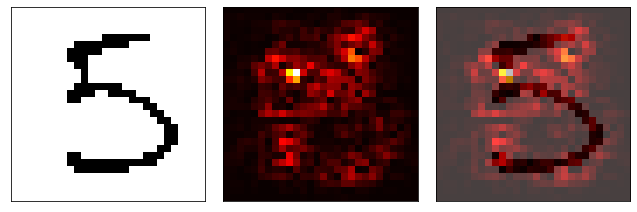

Test image 2:


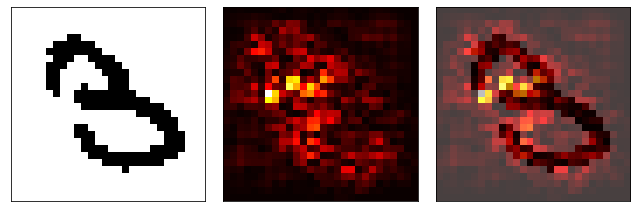

Test image 3:


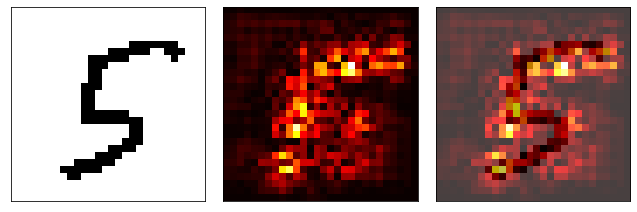

Test image 4:


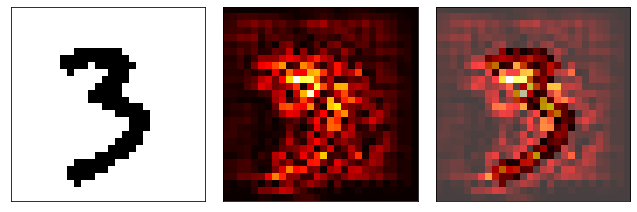

Test image 5:


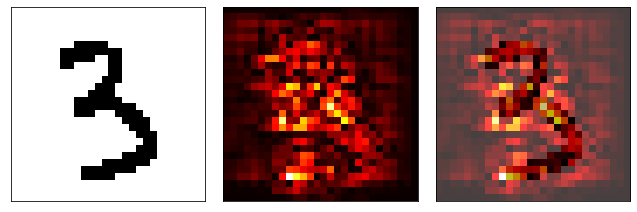

Test image 6:


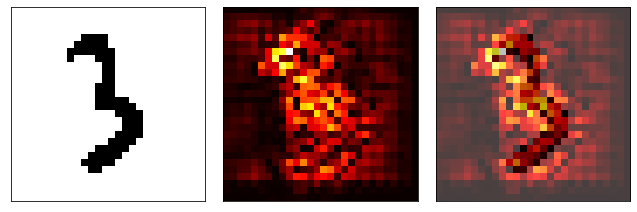

Test image 7:


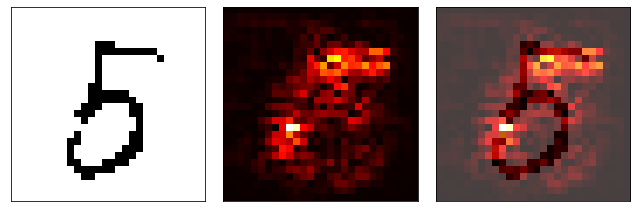

Test image 8:


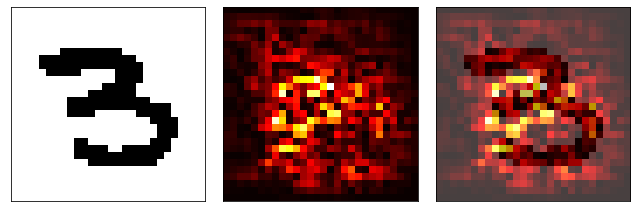

Test image 9:


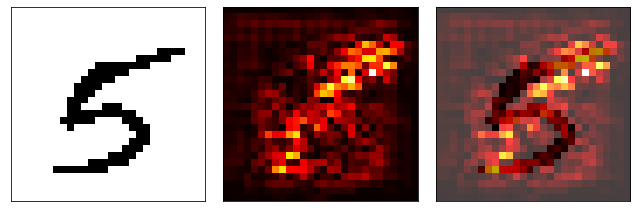

In [8]:
#Run attribution methods

digit_test = np.argmax(y_test, axis=1)

for attr_suffix, attr_method_name in zip(attribution_suffixes, attribution_method_names) :
    
    print("Attribution method = '" + attr_suffix + "'")

    importance_scores_test = _deep_explain(attr_method_name)
    importance_scores_test = np.abs(importance_scores_test)

    #Visualize a few images

    for plot_i in range(0, 10) :

        print("Test image " + str(plot_i) + ":")

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

        ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        plt.sca(ax1)
        plt.xticks([], [])
        plt.yticks([], [])

        ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

        plt.sca(ax2)
        plt.xticks([], [])
        plt.yticks([], [])

        ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

        plt.sca(ax3)
        plt.xticks([], [])
        plt.yticks([], [])

        plt.tight_layout()
        plt.show()

    #Save predicted importance scores

    model_name = "deepexplain_" + dataset_name + "_method_" + attr_suffix

    np.save(model_name + "_importance_scores_test", importance_scores_test)
